## 日本語版
※ ここではGoogle Colaraboratoryでの実行を想定しています。

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [125]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

# (1, 11) -> (11, 1)
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [126]:
n_samples = t_u.shape[0] # 11
n_val = int(0.2 * n_samples) # 2割相当の数

shuffled_indices = torch.randperm(n_samples) # shuffle
print(shuffled_indices)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

tensor([ 7,  9,  4,  3,  2,  6,  8, 10,  0,  5,  1])


(tensor([ 7,  9,  4,  3,  2,  6,  8, 10,  0]), tensor([5, 1]))

In [127]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

print(t_u_train, t_un_train)
print(t_u_val, t_un_val)

tensor([[21.8000],
        [60.4000],
        [56.3000],
        [81.9000],
        [58.2000],
        [33.9000],
        [48.4000],
        [68.4000],
        [35.7000]]) tensor([[2.1800],
        [6.0400],
        [5.6300],
        [8.1900],
        [5.8200],
        [3.3900],
        [4.8400],
        [6.8400],
        [3.5700]])
tensor([[48.9000],
        [55.9000]]) tensor([[4.8900],
        [5.5900]])


In [99]:
# torch.nnモジュール
import torch.nn as nn

linear_model = nn.Linear(1, 1) # コンストラクタ（__init__）の引数（in_features, out_features）
print('w: ', linear_model.weight, '\nb: ', linear_model.bias) # パラメータはランダムで入っている
linear_model(t_un_val) # __call__でforwardする仕様。（linear_model.forward(）ではなく、linear_model()で呼び出すメソッド）

w:  Parameter containing:
tensor([[-0.8671]], requires_grad=True) 
b:  Parameter containing:
tensor([0.4350], requires_grad=True)


tensor([[-2.5044],
        [-6.6665]], grad_fn=<AddmmBackward>)

In [100]:
from pprint import pprint
pprint(list(linear_model.parameters()))

[Parameter containing:
tensor([[-0.8671]], requires_grad=True),
 Parameter containing:
tensor([0.4350], requires_grad=True)]


In [101]:
x = torch.ones(1)
x, linear_model(x)

(tensor([1.]), tensor([-0.4321], grad_fn=<AddBackward0>))

In [102]:
x = torch.ones(10, 1)
x, linear_model(x)

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]), tensor([[-0.4321],
         [-0.4321],
         [-0.4321],
         [-0.4321],
         [-0.4321],
         [-0.4321],
         [-0.4321],
         [-0.4321],
         [-0.4321],
         [-0.4321]], grad_fn=<AddmmBackward>))

In [103]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # iterable parameters
    lr=1e-2)

In [104]:
linear_model.parameters()

<generator object Module.parameters at 0x7f61ae8dcd50>

In [105]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.5423]], requires_grad=True), Parameter containing:
 tensor([-0.5555], requires_grad=True)]

In [106]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # forward (predict)
        loss_train = loss_fn(t_p_train, t_c_train) # loss

        t_p_val = model(t_u_val) # 検証用forward (predict)
        loss_val = loss_fn(t_p_val, t_c_val) # loss
        
        optimizer.zero_grad() # optim初期化
        loss_train.backward() # backward
        optimizer.step() # 反映

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [128]:
# 自分で定義したMSE(Mean square error)を使う場合
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 314.1483, Validation loss 223.2102
Epoch 1000, Training loss 3.8910, Validation loss 1.6322
Epoch 2000, Training loss 3.2980, Validation loss 1.3605
Epoch 3000, Training loss 3.2878, Validation loss 1.3324

Parameter containing:
tensor([[5.3317]], requires_grad=True)
Parameter containing:
tensor([-17.1541], requires_grad=True)


In [129]:
# nn.MSELoss()を使う場合：全く同じ結果になる
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 189.1923, Validation loss 118.9343
Epoch 1000, Training loss 3.8706, Validation loss 1.6259
Epoch 2000, Training loss 3.2976, Validation loss 1.3599
Epoch 3000, Training loss 3.2878, Validation loss 1.3323

Parameter containing:
tensor([[5.3318]], requires_grad=True)
Parameter containing:
tensor([-17.1547], requires_grad=True)


''

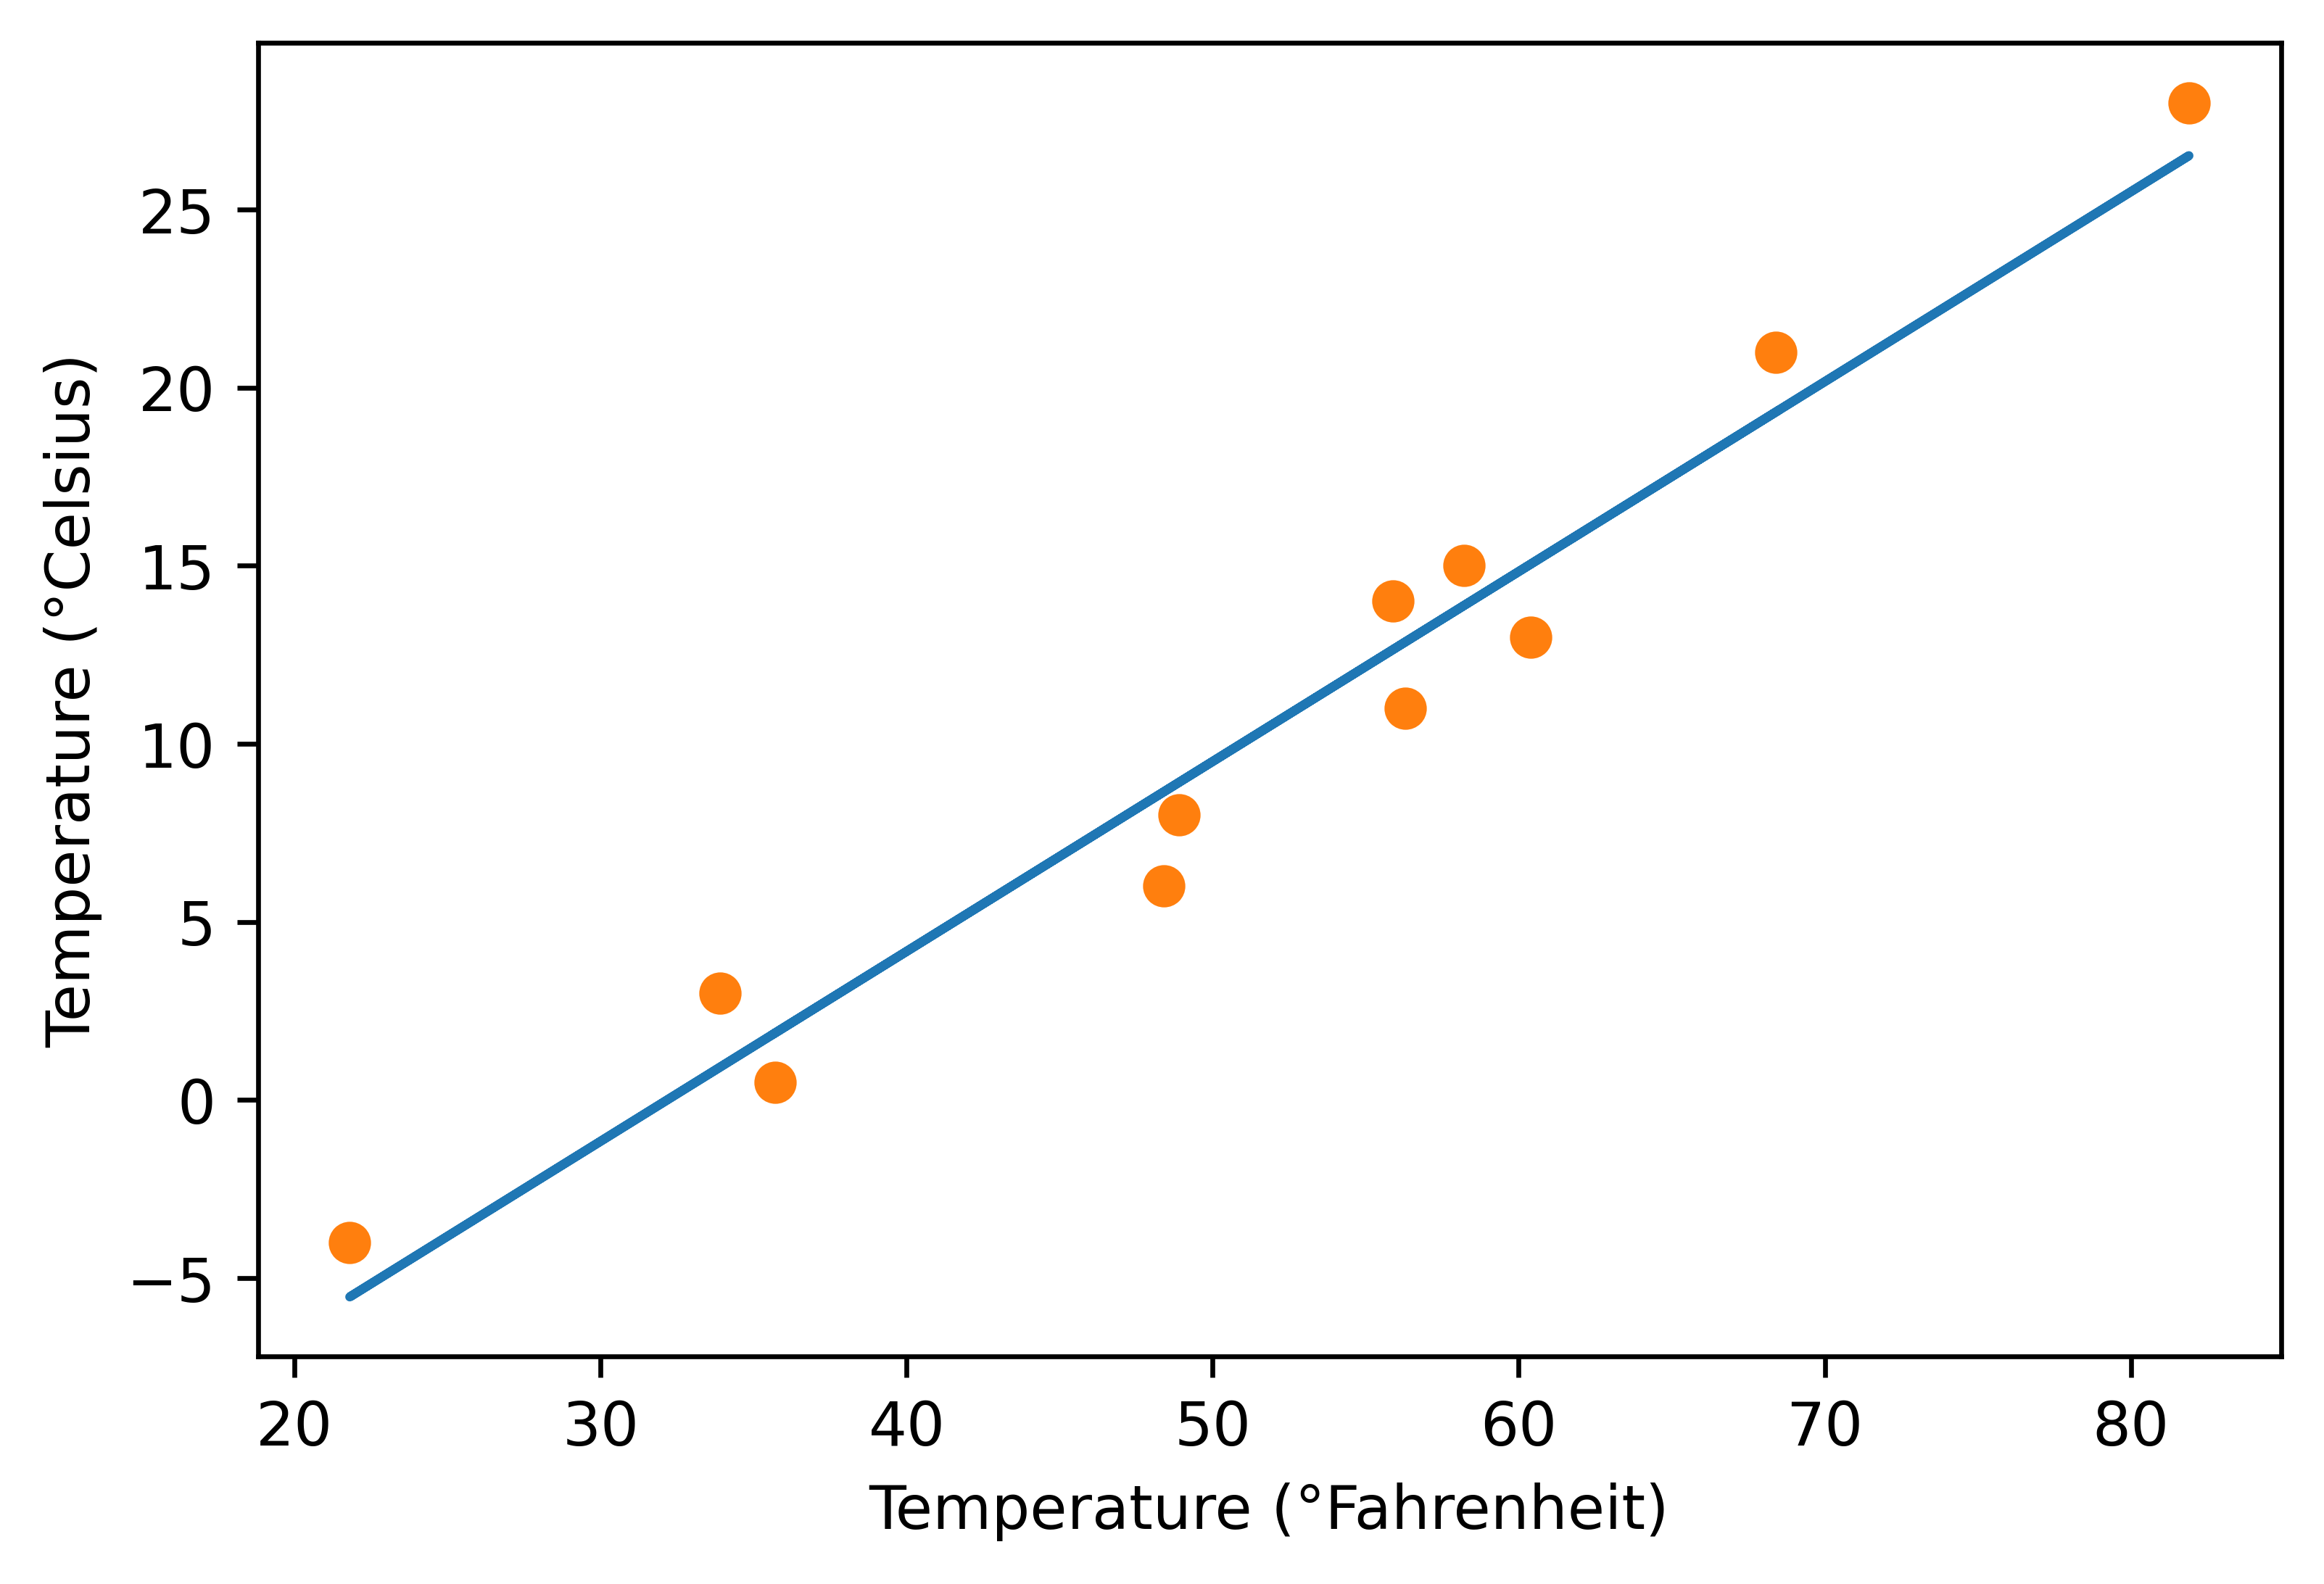

In [130]:
%matplotlib inline
from matplotlib import pyplot as plt

t_un_all = t_u * 0.1
t_p = linear_model(t_un_all) # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

;

## ここからNewral Network

In [110]:
list(nn.Linear(1,1).parameters())

[Parameter containing:
 tensor([[0.7489]], requires_grad=True), Parameter containing:
 tensor([-0.4399], requires_grad=True)]

In [111]:
# 入力値１つ　出力３つ
# w, bの組み合わせ３つを一つの入力に対して適用
linear13 = nn.Linear(1, 3)
print(list(linear13.parameters()))
print(linear13.weight, linear13.weight.shape)
print(linear13.bias, linear13.bias.shape)
print(linear13(torch.Tensor([1])))

[Parameter containing:
tensor([[ 0.2135],
        [ 0.6042],
        [-0.9090]], requires_grad=True), Parameter containing:
tensor([0.5664, 0.0862, 0.5586], requires_grad=True)]
Parameter containing:
tensor([[ 0.2135],
        [ 0.6042],
        [-0.9090]], requires_grad=True) torch.Size([3, 1])
Parameter containing:
tensor([0.5664, 0.0862, 0.5586], requires_grad=True) torch.Size([3])
tensor([ 0.7799,  0.6904, -0.3504], grad_fn=<AddBackward0>)


In [112]:
# 入力値３つ　出力１つ
# w1, w2, w3, b の組み合わせが一つで３つの入力から出力を一つ作成
linear31 = nn.Linear(3, 1)
print(list(linear31.parameters()))
print(linear31.weight, linear31.weight.shape)
print(linear31.bias, linear31.bias.shape)
print(linear31(torch.Tensor([1,2,3])))

[Parameter containing:
tensor([[-0.5666,  0.5691, -0.4830]], requires_grad=True), Parameter containing:
tensor([0.0560], requires_grad=True)]
Parameter containing:
tensor([[-0.5666,  0.5691, -0.4830]], requires_grad=True) torch.Size([1, 3])
Parameter containing:
tensor([0.0560], requires_grad=True) torch.Size([1])
tensor([-0.8216], grad_fn=<AddBackward0>)


In [113]:
# 入力値３つ　出力３つ
# w1, w2, w3, b の組み合わせが3つ で３つの入力から出力を3つ作成
linear33 = nn.Linear(3, 3)
print(list(linear33.parameters()))
print(linear33.weight, linear33.weight.shape)
print(linear33.bias, linear33.bias.shape)
print(linear33(torch.Tensor([1,2,3])))

[Parameter containing:
tensor([[-0.4859, -0.4149,  0.5745],
        [-0.4032, -0.3678, -0.0670],
        [-0.4136, -0.2243,  0.2873]], requires_grad=True), Parameter containing:
tensor([-0.4636, -0.0105, -0.2251], requires_grad=True)]
Parameter containing:
tensor([[-0.4859, -0.4149,  0.5745],
        [-0.4032, -0.3678, -0.0670],
        [-0.4136, -0.2243,  0.2873]], requires_grad=True) torch.Size([3, 3])
Parameter containing:
tensor([-0.4636, -0.0105, -0.2251], requires_grad=True) torch.Size([3])
tensor([-0.0556, -1.3502, -0.2254], grad_fn=<AddBackward0>)


In [131]:
# nn.Sequencialによるネットワーキング
seq_model = nn.Sequential(
            nn.Linear(1, 13), # 適当に13ニューロンに展開
            nn.Tanh(),
            nn.Linear(13, 1)) # 1つの出力に収束させる
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [115]:
# 最初の線形層と最後の線形層のw, bのサイズ
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [116]:
# 層のnumberも出せる
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [133]:
# OrderedDictを用いると層に任意の名前をつけることも可能
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [134]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [135]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.1500], requires_grad=True)

In [136]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # 学習率を変更

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model, # ここをnnモデルに
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 182.8580, Validation loss 111.1597
Epoch 1000, Training loss 4.8697, Validation loss 1.2196
Epoch 2000, Training loss 4.2883, Validation loss 0.3075
Epoch 3000, Training loss 2.2955, Validation loss 1.2846
Epoch 4000, Training loss 1.7241, Validation loss 2.6113
Epoch 5000, Training loss 1.5798, Validation loss 3.2865
output tensor([[ 6.8737],
        [10.9901]], grad_fn=<AddmmBackward>)
answer tensor([[ 8.],
        [14.]])
hidden tensor([[-8.7588],
        [-0.2125],
        [ 8.3835],
        [ 7.7752],
        [ 0.2530],
        [ 0.2370],
        [-0.0091],
        [ 4.3786]])


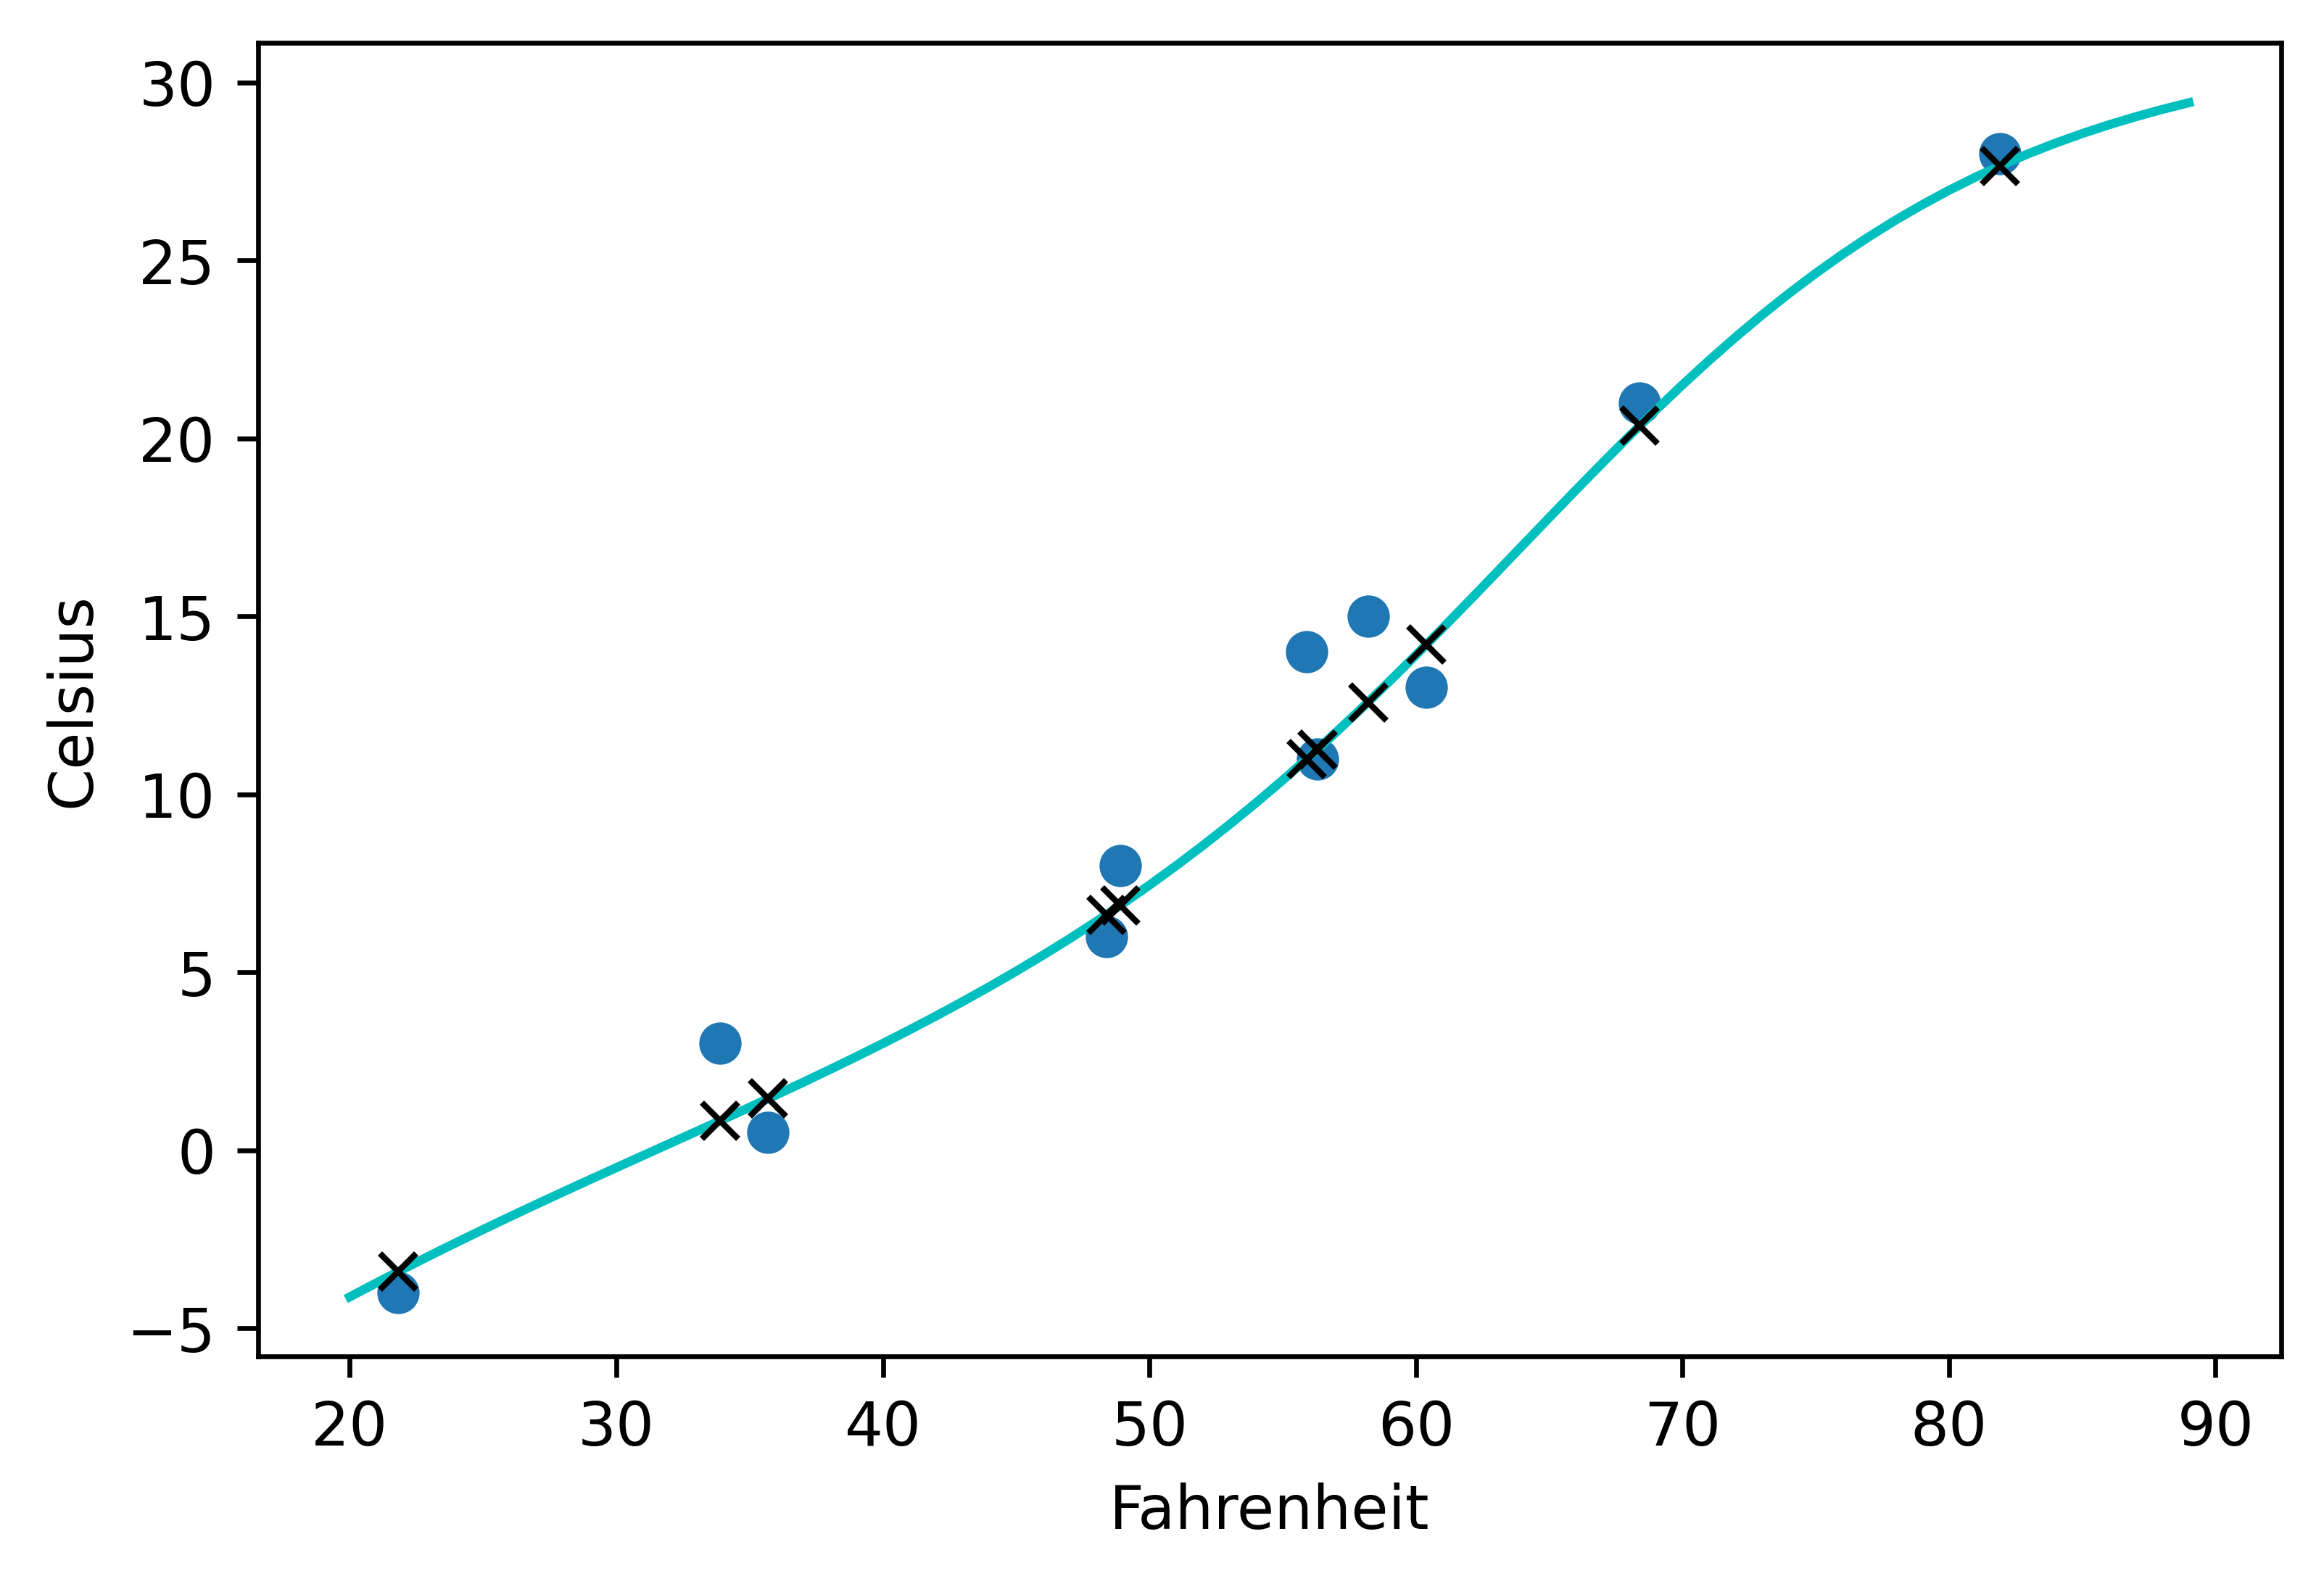

In [137]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 186.0011, Validation loss 128.0049
Epoch 1000, Training loss 59.8093, Validation loss 7.9364
Epoch 2000, Training loss 43.7558, Validation loss 6.1755
Epoch 3000, Training loss 30.1984, Validation loss 4.7208
Epoch 4000, Training loss 19.3475, Validation loss 3.3752
Epoch 5000, Training loss 12.2176, Validation loss 2.3307
Epoch 6000, Training loss 8.1505, Validation loss 1.6538
Epoch 7000, Training loss 5.9400, Validation loss 1.2797
Epoch 8000, Training loss 4.6981, Validation loss 1.1033
Epoch 9000, Training loss 3.9448, Validation loss 1.0392
Epoch 10000, Training loss 3.4495, Validation loss 1.0348


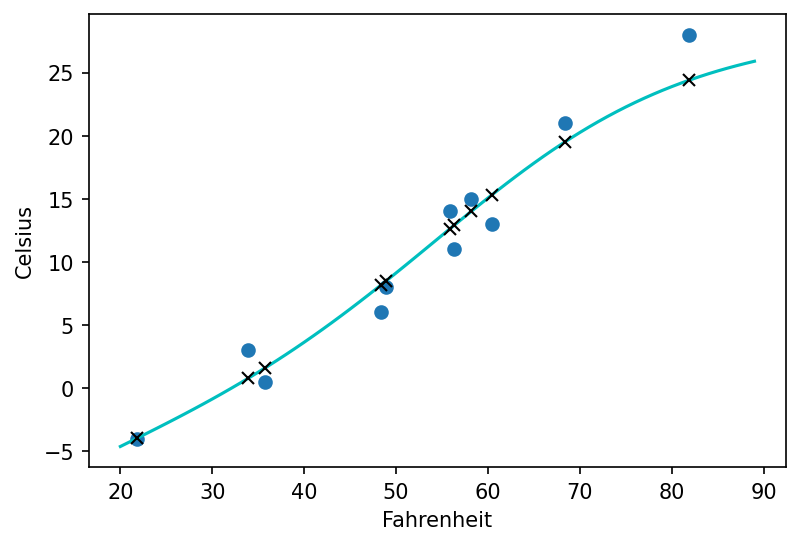

In [139]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 10000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_u * 0.1,
    t_u_val = t_un_val, 
    t_c_train = t_c,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
